# **IDL Project: Predicting BCI_EEG signals using Deep Learning**

In [110]:
!pip install wandb --quiet
import os

import torch
import torch.nn as nn
from torchsummary import summary
import torchvision

import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import glob
import wandb
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy

In [111]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cpu


In [3]:
# Get BCI_EEG Data 
!mkdir /content/bci_data
!wget -q https://cmu.box.com/shared/static/dje4whisfwszhe2vvfphvahzr563kp2x.zip --content-disposition --show-progress
!unzip -qo 'BCI_EEG_data.zip' -d '/content/bci_data'

"""
Original Data From:
 *https://figshare.com/articles/online_resource/Shared_data_for_exploring_training_effect_in_42_human_subjects_using_a_noninvasive_sensorimotor_rhythm-based_online_BCI/7959572*
"""

BCI_EEG_data.zip    100%[===================>]   4.84G  11.4MB/s    in 7m 51s  


'\nOriginal Data From:\n *https://figshare.com/articles/online_resource/Shared_data_for_exploring_training_effect_in_42_human_subjects_using_a_noninvasive_sensorimotor_rhythm-based_online_BCI/7959572*\n'

# **EDA**

---
...Each file includes the online results from the BCI experimentation for each run (saved in a cell variable ‘BCI_UseResults’), key parameters for the experiment (saved in a structure ‘Experiment_Parm’), key parameters for the state of the raw EEG signal (saved in a structure ‘Experimental_states’), and the raw EEG signal (saved in a variable ‘output_data’).

The raw EEG signals for experiments one and two are composed of 62 channels of EEG data with a sampling frequency of 100Hz, while data for experiment three contains 64 channels of EEG sampled at 128Hz...

In [112]:
# Loads a single .mat file into dictionary where {key=str, value=np.ndarray}
mat = scipy.io.loadmat('/content/bci_data/Exp1/Subj10_S01_Exp1.mat') 

#HIgh-Level Description of Dataset
#print(mat.keys())
#for i in mat.keys():
#    print(f'Dictionary Key: {i} (dtype: {type(i)})')
#    if isinstance(mat[i], np.ndarray):
#        print(f'Dictionary Value (dtype: {type(mat[i])}) shape: {mat[i].shape} ')
#    else: print(f'{mat[i]}')

#New variable to load formatted data
dat = dict()
dat['raw_eeg'] = mat['output_data']
 
# Reformatting 'BCI_UseResults' into a dictionary
bci_useresults = dict()
for i in mat['BCI_UseResults']:
    bci_useresults[i[1][0]] = i[0].flatten()

dat['bci_useresults'] = bci_useresults #Add formatted data to dictionary

# Reformatting 'Experiment_Parm' into a dictionary
exp_parm = dict()
for _ in mat['Experiment_Parm']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_parm[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_parm'] = exp_parm

# Reformatting 'Experimental_states' into a dictionary
exp_states = dict()
for _ in mat['Experimental_states']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_states[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_states'] = exp_states

print(f'New variable "dat" has keys: {dat.keys()}')
for key in dat.keys():
    print('--------------------------------')
    if key != 'raw_eeg':  
        print(f'Key: [{key}] contains a nested dictionary as its value:')
        for j in dat[key].keys():
            print(f'(Nested) Key: {j} ->  Input Shape: {dat[key][j].shape}')
    else: print(f'Key:[{key}] -> Input Shape:{dat[key].shape}')

New variable "dat" has keys: dict_keys(['raw_eeg', 'bci_useresults', 'exp_parm', 'exp_states'])
--------------------------------
Key:[raw_eeg] -> Input Shape:(142080, 62)
--------------------------------
Key: [bci_useresults] contains a nested dictionary as its value:
(Nested) Key: Number of trials in each run ->  Input Shape: (5,)
(Nested) Key: Number of trials hitting the targets ->  Input Shape: (5,)
(Nested) Key: Number of trials abort ->  Input Shape: (5,)
(Nested) Key: The percent valid correct for each run ->  Input Shape: (5,)
(Nested) Key: Information transfer rate for each run ->  Input Shape: (5,)
--------------------------------
Key: [exp_parm] contains a nested dictionary as its value:
(Nested) Key: PreFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: SamplingFrequency ->  Input Shape: (1,)
(Nested) Key: PostFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: ITIDuration ->  Input Shape: (1,)
(Nested) Key: Channels ->  Input Shape: (62,)
(Nested) Key: Description ->  I

In [113]:
"""
TODOs: 
1. Format the 'output_data' into torch.Tensor to make it trainable on a neural network
"""
        
# Attempt 1: Use Pandas to display the exp_ s
df_exp_states = pd.DataFrame.from_dict(exp_states)
display(df_exp_states)
df_exp_states['CursorPosX'].unique()
df_exp_states['TargetCode'].unique()

,TargetCode,ResultCode,Feedback,CursorPosX,CursorPosY
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
142075,2,2,0,520,2047
142076,2,2,0,520,2047
142077,2,2,0,520,2047
142078,2,2,0,520,2047


array([0, 2, 1], dtype=uint8)

In [114]:
 # YHH
# targets = mat['Experimental_states']['TargetCode']
# targets = targets[0][0]
# targets = np.squeeze(targets)
# print(targets)
# print(exp_states['TargetCode'])
# exp_states['CursorPosX']
targets = exp_states['TargetCode']
# trial_start_index = np.nonzero(np.diff(targets))[0][::2]+1
# trial_start_end_index = np.nonzero(np.diff(targets))[0]+1
test = np.nonzero(np.diff(targets))[0]+1
print(test)

[   504   1508   1808   2812   3112   4056   4356   5012   5312   6152
   6452   7340   7640   8644   8944   9828  10128  11020  11320  12212
  12512  13516  13816  14712  15012  15612  15912  16916  17216  18120
  18420  19300  19600  20332  20632  21308  21608  22284  22584  23460
  23760  24700  25000  26004  26304  27308  27608  28512  28812  29276
  29780  30392  30692  31228  31528  32180  32480  33328  33628  34632
  34932  35936  36236  37044  37344  38348  38648  39292  39592  40312
  40612  41616  41916  42676  42976  43980  44280  44936  45236  45868
  46168  47000  47300  48304  48604  49608  49908  50836  51136  52140
  52440  53240  53540  54544  54844  55848  56148  56708  57008  58012
  58516  59348  59648  60268  60568  61348  61648  62652  62952  63948
  64248  64848  65148  66152  66452  67456  67756  68760  69060  70064
  70364  71284  71584  72588  72888  73892  74192  75196  75496  76388
  76688  77692  77992  78460  78760  79252  79552  80088  80388  81116
  8141

In [115]:
targets = mat['Experimental_states']['TargetCode']
cursor = mat['Experimental_states']['CursorPosX']

targets = targets[0][0]
targets = np.squeeze(targets)

# Maybe we can use the dict that Robin prepared to extract the targets?
targets = exp_states['TargetCode']
results = exp_states['ResultCode']
# cursor = exp_states['CursorPosX']

raw_eeg = mat['output_data']

# Get indices for the start/end of  each trial
trial_start_index = np.nonzero(np.diff(targets))[0][::2]+1
trial_start_end_index = np.nonzero(np.diff(targets))[0]+1

# labels to ConvNet in one data file
targets = targets[trial_start_index]
results = results[trial_start_index]
print("labels: ")
print(targets.shape)
print(targets)
print(results)
print('-----------------------------------------------')
print("minimum trial duration: ", np.amin(np.diff(trial_start_end_index)[::2]))

raw_eeg = np.split(raw_eeg,trial_start_end_index)[1::2]
input = []

for eeg in raw_eeg:
  # index 210 to 310 (1s) because the motor imgination starts 2s after the target shows up. 210 is 2s (200) plus 0.1s (10) reaction time. 
  # The target will freeze on the screen for 1s and the shortest trial only lasts for 4.3 seconds so the upper bound needs to be <330, 4.32 (432) minus 1s (100).
  # 310 is taken to round to 100
  input.append(eeg[210:310,:])

# inputs to ConvNet in one data file
input = np.array(input)
print("input: ")
print(input.shape)






labels: 
(125,)
[2 1 2 1 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 1 2 1 2 2 1 1 2 1 2 1 2 2 1 2
 1 2 1 2 1 2 1 1 2 1 2 2 1 1 2 1 2 2 1 2 1 2 1 1 2 1 2 2 1 1 2 1 2 1 2 2 1
 1 2 2 1 2 1 2 1 2 1 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 2 1 2 2 1 2 1 2 1 1 2 1
 2 2 1 1 2 1 2 1 2 1 2 2 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
-----------------------------------------------
minimum trial duration:  432
input: 
(125, 100, 62)


There are total of 125 trials in each data file. The code below visualizes the first three trials with curosr position on the left and eeg signals o nthe right.

# Visualization

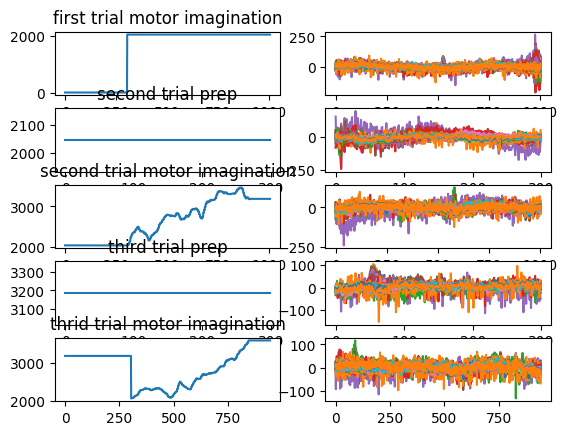

In [116]:
# DataData Visualization
import matplotlib.pyplot as plt

cursor = mat['Experimental_states']['CursorPosX']
cursor = cursor[0][0]
cursor = np.squeeze(cursor)
raw_eeg = mat['output_data']

plt.subplot(5,2,1)
plt.plot(cursor[trial_start_end_index[0]:trial_start_end_index[1]]);
plt.title("first trial motor imagination")
plt.subplot(5,2,2)
plt.plot(raw_eeg[trial_start_end_index[0]:trial_start_end_index[1],:]);

plt.subplot(5,2,3)
plt.plot(cursor[trial_start_end_index[1]:trial_start_end_index[2]]);
plt.title("second trial prep")
plt.subplot(5,2,4)
plt.plot(raw_eeg[trial_start_end_index[1]:trial_start_end_index[2],:]);

plt.subplot(5,2,5)
plt.plot(cursor[trial_start_end_index[2]:trial_start_end_index[3]]);
plt.title("second trial motor imagination")
plt.subplot(5,2,6)
plt.plot(raw_eeg[trial_start_end_index[2]:trial_start_end_index[3],:]);

plt.subplot(5,2,7)
plt.plot(cursor[trial_start_end_index[3]:trial_start_end_index[4]]);
plt.title("third trial prep")
plt.subplot(5,2,8)
plt.plot(raw_eeg[trial_start_end_index[3]:trial_start_end_index[4],:]);

plt.subplot(5,2,9)
plt.plot(cursor[trial_start_end_index[4]:trial_start_end_index[5]]);
plt.title("thrid trial motor imagination")
plt.subplot(5,2,10)
plt.plot(raw_eeg[trial_start_end_index[4]:trial_start_end_index[5],:]);

In [117]:
# Loads a single .mat file into dictionary where {key=str, value=np.ndarray}
mat = scipy.io.loadmat('/content/bci_data/Exp1/Subj10_S01_Exp1.mat') 

#HIgh-Level Description of Dataset
#print(mat.keys())
#for i in mat.keys():
#    print(f'Dictionary Key: {i} (dtype: {type(i)})')
#    if isinstance(mat[i], np.ndarray):
#        print(f'Dictionary Value (dtype: {type(mat[i])}) shape: {mat[i].shape} ')
#    else: print(f'{mat[i]}')

#New variable to load formatted data
dat = dict()
dat['raw_eeg'] = mat['output_data']
 
# Reformatting 'BCI_UseResults' into a dictionary
bci_useresults = dict()
for i in mat['BCI_UseResults']:
    bci_useresults[i[1][0]] = i[0].flatten()

dat['bci_useresults'] = bci_useresults #Add formatted data to dictionary

# Reformatting 'Experiment_Parm' into a dictionary
exp_parm = dict()
for _ in mat['Experiment_Parm']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_parm[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_parm'] = exp_parm

# Reformatting 'Experimental_states' into a dictionary
exp_states = dict()
for _ in mat['Experimental_states']:
    for wrapper in _:
        fieldnames = wrapper.dtype.names
        for idx, val in enumerate(wrapper):
            exp_states[f'{fieldnames[idx]}'] = val.flatten()

dat['exp_states'] = exp_states

print(f'New variable "dat" has keys: {dat.keys()}')
for key in dat.keys():
    print('--------------------------------')
    if key != 'raw_eeg':  
        print(f'Key: [{key}] contains a nested dictionary as its value:')
        for j in dat[key].keys():
            print(f'(Nested) Key: {j} ->  Input Shape: {dat[key][j].shape}')
    else: print(f'Key:[{key}] -> Input Shape:{dat[key].shape}')

New variable "dat" has keys: dict_keys(['raw_eeg', 'bci_useresults', 'exp_parm', 'exp_states'])
--------------------------------
Key:[raw_eeg] -> Input Shape:(142080, 62)
--------------------------------
Key: [bci_useresults] contains a nested dictionary as its value:
(Nested) Key: Number of trials in each run ->  Input Shape: (5,)
(Nested) Key: Number of trials hitting the targets ->  Input Shape: (5,)
(Nested) Key: Number of trials abort ->  Input Shape: (5,)
(Nested) Key: The percent valid correct for each run ->  Input Shape: (5,)
(Nested) Key: Information transfer rate for each run ->  Input Shape: (5,)
--------------------------------
Key: [exp_parm] contains a nested dictionary as its value:
(Nested) Key: PreFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: SamplingFrequency ->  Input Shape: (1,)
(Nested) Key: PostFeedbackDuration ->  Input Shape: (1,)
(Nested) Key: ITIDuration ->  Input Shape: (1,)
(Nested) Key: Channels ->  Input Shape: (62,)
(Nested) Key: Description ->  I

In [118]:
# dat['exp_states']['TargetCode'].shape
exp_states['ResultCode'].shape

(142080,)

# Dataset

In [167]:
def compute_psd(eeg_data, sampling_rate):
    freqs, psd = scipy.signal.welch(eeg_data, sampling_rate)
    return freqs, psd

def extract_alpha_beta_power(eeg_data, sampling_rate):
    freqs, psd = compute_psd(eeg_data, sampling_rate)
    # print("freqs: ", freqs, "freq max: ", np.max(freqs), "freq min: ", np.min(freqs))
    # print("psd: ", psd, "psd max: ", np.max(psd), "psd min: ", np.min(psd))
    alpha_idx = np.where((freqs >= 8) & (freqs <= 12))
    beta_idx = np.where((freqs > 12) & (freqs <= 30))
    
    alpha_power = np.sum(psd[alpha_idx])
    beta_power = np.sum(psd[beta_idx])
    # print("alpha_power: ", alpha_power)
    # print("beta_power: ", beta_power)
    return alpha_power, beta_power


In [168]:
class SubjectDataset(torch.utils.data.Dataset):

    def __init__(self, root, subject = 1, mode = 'train'):

        self.eegs, self.results = [], []
        self.alpha_beta_powers = []
        for experiment in ["Exp1","Exp2"]:
     
            dir = root + '/' + experiment
            for session in os.listdir(dir):

                should_load = f'Subj{subject}_' in session
                if mode == 'train':
                    should_load = not should_load
                
                if should_load:
                    # Load a single mat file
                    mat = scipy.io.loadmat(dir+'/'+session)
                    
                    # Get raw EEG data in one session
                    session_eeg = mat['output_data']
                    
                    # Get target code in one session
                    exp_states = dict()
                    for _ in mat['Experimental_states']:
                        for wrapper in _:
                            fieldnames = wrapper.dtype.names
                            for idx, val in enumerate(wrapper):
                                exp_states[f'{fieldnames[idx]}'] = val.flatten()
                    session_targetCode = exp_states['TargetCode']-1

                    
                    '''
                    TODO: The different effective length of 3 sessions will cause problems for data loader.
                    --> for now, we use a fix number 100 as the effective duration
                    --> If this impacts the model performance, we can try pad_pack_sequence
                    '''
                    
                    # Remove useless data
                    trial_start_index = np.nonzero(np.diff(session_targetCode))[0][::2]+1
                    trial_start_end_index = np.nonzero(np.diff(session_targetCode))[0]+1

                    # Split continuous eeg data to trials
                    eeg_split_trials = np.split(session_eeg,trial_start_end_index)[1::2]
                    
                    # Motor imgination starts 2s after the target shows up. Plus 0.1s for reactions time
                    effective_start = 210
                    
                    # The target freezes for 1s after hitting the target, signals in this 1s is useless.
                    # Use the min duration time - 1s as the effective end time. 
                    # Different sessions have different min duration time
                    # min_trial_duration = np.amin(np.diff(trial_start_end_index)[::2])
                    # effective_end = min_trial_duration - 100
                    
                    # Update: for now, we use a fix number 100 as the effective duration
                    effective_end = effective_start + 100
                    
                    effective_eeg = []
                    for eeg in eeg_split_trials:
                        # mean = np.mean(eeg[effective_start:effective_end,:])
                        # std = np.std(eeg[effective_start:effective_end,:])
                        # eeg[effective_start:effective_end,:] = (eeg[effective_start:effective_end,:] - mean) / std
                        eeg_standardized = np.zeros_like(eeg[effective_start:effective_end,:])
                        mean = 0
                        var = 0
                        alpha = 0.999
                        for t in range(eeg[effective_start:effective_end,:].shape[0]):
                            mean = alpha * mean + (1 - alpha) * eeg[effective_start:effective_end,:][t]
                            var = alpha * var + (1 - alpha) * (eeg[effective_start:effective_end,:][t] - mean) ** 2
                            eeg_standardized[t] = (eeg[effective_start:effective_end,:][t] - mean) / np.sqrt(var + 1e-8)
                        # effective_eeg.append(eeg[effective_start:effective_end,:])
                        effective_eeg.append(eeg_standardized)
                        # print("eeg_standardized: ",eeg_standardized, "eeg max: ", np.max(eeg_standardized), "eeg min: ", np.min(eeg_standardized))
                        alpha_power, beta_power = extract_alpha_beta_power(eeg_standardized, 100)
                        self.alpha_beta_powers.append(np.array([alpha_power, beta_power]))
        
                    
                    # Remove useless target code
                    session_targetCode = session_targetCode[trial_start_index]

                    # print(min_trial_duration)
                    # print(np.array(effective_eeg).shape)
                    # print(len(session_targetCode))
                    # print(session_targetCode)
                    print("mode: ", mode)
                    print("session: ",session)
                    print("len: ",len(effective_eeg))
                    # Add the session data into the array
                    self.eegs += (effective_eeg)
                    self.results.append(session_targetCode)
        
        # Concatenate results
        self.results = np.concatenate(self.results)
        
        # print(self.eegs[0].shape)
        # print(self.eegs[125].shape)
        # print(self.eegs[250].shape)
        # print(len(self.results))
            
        self.length = len(self.results)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        eegs = np.array([self.eegs[ind]]) # extra [] to make an additional dimension for channel
        eegs = torch.FloatTensor(eegs)

        alpha_beta_power = np.array([self.alpha_beta_powers[ind]])
        alpha_beta_power = torch.FloatTensor(alpha_beta_power)

        results = torch.tensor(self.results[ind])
        return (eegs, alpha_beta_power), results

    '''
    TODO: Discuss if we need batch-wise operations.
    '''
    # def collate_fn(batch):
    #     return batch



In [169]:
# Test of dataset and data loader
root = '/content/bci_data'
train_dataset = SubjectDataset(root, subject=1, mode = 'train')
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    num_workers = 4,
    batch_size  = 8, 
    pin_memory  = True,
    shuffle     = True,
    # collate_fn  = AudioDataset.collate_fn
)

test_dataset = SubjectDataset(root, subject=1, mode = 'test')
test_loader = torch.utils.data.DataLoader(
    dataset     = test_dataset, 
    num_workers = 4,
    batch_size  = 8, 
    pin_memory  = True,
    shuffle     = False,
    # collate_fn  = AudioDataset.collate_fn
)

/usr/local/lib/python3.9/dist-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 62, using nperseg = 62
  warnings.warn('nperseg = {0:d} is greater than input length '


mode:  train
session:  Subj10_S02_Exp1.mat
len:  125
mode:  train
session:  Subj4_S03_Exp1.mat
len:  125
mode:  train
session:  Subj5_S02_Exp1.mat
len:  125
mode:  train
session:  Subj14_S01_Exp1.mat
len:  125
mode:  train
session:  Subj2_S02_Exp1.mat
len:  125
mode:  train
session:  Subj10_S01_Exp1.mat
len:  125
mode:  train
session:  Subj14_S02_Exp1.mat
len:  125
mode:  train
session:  Subj4_S02_Exp1.mat
len:  125
mode:  train
session:  Subj11_S02_Exp1.mat
len:  125
mode:  train
session:  Subj2_S03_Exp1.mat
len:  125
mode:  train
session:  Subj8_S03_Exp1.mat
len:  125
mode:  train
session:  Subj16_S01_Exp1.mat
len:  125
mode:  train
session:  Subj11_S03_Exp1.mat
len:  125
mode:  train
session:  Subj16_S03_Exp1.mat
len:  125
mode:  train
session:  Subj5_S03_Exp1.mat
len:  125
mode:  train
session:  Subj13_S03_Exp1.mat
len:  125
mode:  train
session:  Subj3_S01_Exp1.mat
len:  125
mode:  train
session:  Subj9_S01_Exp1.mat
len:  125
mode:  train
session:  Subj2_S01_Exp1.mat
len:  125
mod

In [170]:
print("No. of data         : ", train_dataset.__len__())
print("No. of test data         : ", test_dataset.__len__())
print("Shape of data       : ", train_dataset[0][0][0].shape)
# print("Batch size           : ", config['batch_size'])
print("Train batches       : ", train_loader.__len__())
print("Test batches        : ", test_loader.__len__())

No. of data         :  9945
No. of test data         :  375
Shape of data       :  torch.Size([1, 100, 62])
Train batches       :  1244
Test batches        :  47


In [171]:
gc.collect() # These commands help you when you face CUDA OOM error
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.cuda.empty_cache()

In [172]:
# Test of dataset and data loader
for x, y in train_loader:
    print(x[0].shape, x[1].shape, y.shape)
  
    break

torch.Size([8, 1, 100, 62]) torch.Size([8, 1, 2]) torch.Size([8])


# Model

In [16]:
class ShallowConvNet(nn.Module):
    def __init__(self, in_channels = 62, n_classes = 2, conv_stride = 1, batch_norm_alpha=0.1, drop_prob=0.5):
        super().__init__()

        self.layers = nn.Sequential(
            # Conv Pool Block 1
            nn.Conv2d(1, 40, (25, 1)),
            nn.Conv2d(40, 40, (1, in_channels), stride= 1 , bias=False),
            nn.BatchNorm2d(40, momentum=batch_norm_alpha, affine=True, eps=1e-5,),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(3, 1)),

            # # Conv Pool Block 2
            # nn.Dropout(p=drop_prob),
            # nn.Conv2d(25, 50, (10, 1), bias=False),
            # nn.BatchNorm2d(50, momentum=batch_norm_alpha),
            # nn.ELU(),
            # nn.MaxPool2d((3, 1), stride=(3, 1)),

            # # Conv Pool Block 3
            # nn.Dropout(p=drop_prob),
            # nn.Conv2d(50, 100, (10, 1), bias=False),
            # nn.BatchNorm2d(100, momentum=batch_norm_alpha),
            # nn.ELU(),
            # nn.MaxPool2d((3, 1), stride=(3, 1)),

            # # Conv Pool Block 4
            # nn.Dropout(p=drop_prob),
            # nn.Conv2d(100, 200, (10, 1), bias=False),
            # nn.BatchNorm2d(200, momentum=batch_norm_alpha),
            # nn.ELU(),
            # nn.MaxPool2d((3, 1), stride=(3, 1)),

            # # Classification Layer
            # nn.Conv2d(200, n_classes, (2,1), bias=True),
            # nn.LogSoftmax(dim=1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

In [17]:
class DeepConvNet(nn.Module):
    def __init__(self, in_channels = 62, n_classes = 2, conv_stride = 1, batch_norm_alpha=0.1, drop_prob=0.5):
        super().__init__()

        self.layers = nn.Sequential(
            # Conv Pool Block 1
            nn.Conv2d(1, 25, (8, 1)),
            nn.Conv2d(25, 25, (1, in_channels), stride=(conv_stride, 1), bias=False),
            nn.BatchNorm2d(25, momentum=batch_norm_alpha, affine=True, eps=1e-5,),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(2, 1)),

            # Conv Pool Block 2
            nn.Dropout(p=drop_prob),
            nn.Conv2d(25, 50, (8, 1), bias=False),
            nn.BatchNorm2d(50, momentum=batch_norm_alpha),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(1, 1)),

            # Conv Pool Block 3
            nn.Dropout(p=drop_prob),
            nn.Conv2d(50, 100, (8, 1), bias=False),
            nn.BatchNorm2d(100, momentum=batch_norm_alpha),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(1, 1)),

            # Conv Pool Block 4
            nn.Dropout(p=drop_prob),
            nn.Conv2d(100, 200, (4, 1), bias=False),
            nn.BatchNorm2d(200, momentum=batch_norm_alpha),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(1, 1)),

            # # Classification Layer
            nn.Conv2d(200, n_classes, (23,1), bias=True),
            nn.Flatten(),
            nn.LogSoftmax(dim=1)
        )
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

In [173]:
class DeepConvNetWithAlphaBeta(nn.Module):
    def __init__(self, in_channels = 62, n_classes = 2, conv_stride = 1, batch_norm_alpha=0.1, drop_prob=0.5):
        super().__init__()

        self.layers = nn.Sequential(
            # Conv Pool Block 1
            nn.Conv2d(1, 25, (8, 1)),
            nn.Conv2d(25, 25, (1, in_channels), stride=(conv_stride, 1), bias=False),
            nn.BatchNorm2d(25, momentum=batch_norm_alpha, affine=True, eps=1e-5,),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(2, 1)),

            # Conv Pool Block 2
            nn.Dropout(p=drop_prob),
            nn.Conv2d(25, 50, (8, 1), bias=False),
            nn.BatchNorm2d(50, momentum=batch_norm_alpha),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(1, 1)),

            # Conv Pool Block 3
            nn.Dropout(p=drop_prob),
            nn.Conv2d(50, 100, (8, 1), bias=False),
            nn.BatchNorm2d(100, momentum=batch_norm_alpha),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(1, 1)),

            # Conv Pool Block 4
            nn.Dropout(p=drop_prob),
            nn.Conv2d(100, 200, (4, 1), bias=False),
            nn.BatchNorm2d(200, momentum=batch_norm_alpha),
            nn.ELU(),
            nn.MaxPool2d((3, 1), stride=(1, 1)),

            # # Classification Layer
            # nn.Conv2d(200, n_classes, (23,1), bias=True),
            # nn.Flatten(),
            # nn.LogSoftmax(dim=1)
        )

        self.classificationLayers = nn.Sequential(
            # Classification Layer
            nn.Conv2d(202, n_classes, (23,1), bias=True),
            nn.Flatten(),
            nn.LogSoftmax(dim=1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight, gain=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        eegs, alpha_beta_power = x[0], x[1]
        features = self.layers(eegs)  # Process input through all layers except the last 3 (classification layer, Flatten, and LogSoftmax)
        # print("features.shape: ", features.shape)
        # print("alpha_beta_power.shape: ", alpha_beta_power.shape)

        # Concatenate the precomputed alpha and beta power features with the output from the final convolutional layer
        alpha_beta_power = alpha_beta_power.view(alpha_beta_power.size(0), -1, 1, 1)  # Reshape the alpha_beta_power tensor
        alpha_beta_power = alpha_beta_power.expand(-1, -1, features.size(2), -1)  # Expand alpha_beta_power tensor to match features tensor dimensions
        # print("expanded alpha beta power shape: ", alpha_beta_power.shape)

        features = torch.cat([features, alpha_beta_power], dim=1)  # Concatenate along the channel dimension
        # print("concatenated shape: ", features.shape)

        # Pass the concatenated features through the classification layer
        output = self.classificationLayers(features)
        # print("output shape: ", output.shape)
        return output




In [174]:
# model = DeepConvNet(62, 2).to(DEVICE)
model = DeepConvNetWithAlphaBeta(62, 2).to(DEVICE)
# summary(model, (1, 100, 62))
def custom_summary(model, eegs_shape, alpha_beta_shape):
    eegs = torch.rand(eegs_shape)
    alpha_beta_power = torch.rand(alpha_beta_shape)
    output = model((eegs, alpha_beta_power))
    print("Output shape: ", output.shape)

eegs_shape = (8, 1, 100, 62)
alpha_beta_shape = (8, 1, 2)
custom_summary(model, eegs_shape, alpha_beta_shape)


Output shape:  torch.Size([8, 2])


In [175]:
criterion = torch.nn.NLLLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, patience = 5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#         optimizer=optimizer,
#         T_max = config['epochs']
# )
# scaler = torch.cuda.amp.GradScaler()

In [176]:
config = {
    'epochs'        : 10,
    'batch_size'    : 8,
    'lr'            : 0.01, # 0.1 for SGD, 5e-4 for adamW
    'patience'      : 2,
    'lr_decay'      : 0.1,
    'weight_decay'  : 0.001,
    'momentum'      : 0.9,
    'nesterov'      : True,
    'drop_rate'     : 0.25,
    'label_smooth'  : 0.1,
    'drop_path'     : 0.1
}

In [21]:
# def train(model, dataloader, optimizer, criterion):
    
#     model.train()

#     # Progress Bar 
#     batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

#     num_correct = 0
#     total_loss  = 0

#     for i, (images, labels) in enumerate(dataloader):
        
#         optimizer.zero_grad() # Zero gradients

#         images, labels = images.to(DEVICE), labels.to(DEVICE)
        
#         with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it! 
#             outputs = model(images)
#             loss    = criterion(outputs, labels)

#         # Update no. of correct predictions & loss as we iterate
#         num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
#         total_loss      += float(loss.item())

#         # tqdm lets you add some details so you can monitor training as you train.
#         batch_bar.set_postfix(
#             acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
#             loss        = "{:.04f}".format(float(total_loss / (i + 1))),
#             num_correct = num_correct,
#             lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
#         )
        
#         loss.backward()
#         optimizer.step()
#         # scaler.scale(loss).backward() # This is a replacement for loss.backward()
#         # scaler.step(optimizer) # This is a replacement for optimizer.step()
#         # scaler.update() 

#         # TODO? Depending on your choice of scheduler,
#         # You may want to call some schdulers inside the train function. What are these?
      
#         batch_bar.update() # Update tqdm bar

#     batch_bar.close() # You need this to close the tqdm bar

#     acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
#     total_loss  = float(total_loss / len(dataloader))

#     return acc, total_loss

In [164]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss = 0

    for i, ((eegs, alpha_beta_power), labels) in enumerate(dataloader):
        optimizer.zero_grad()  # Zero gradients

        eegs, alpha_beta_power, labels = eegs.to(DEVICE), alpha_beta_power.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast():  # This implements mixed precision. That's it!
            outputs = model((eegs, alpha_beta_power))
            loss = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size'] * (i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        loss.backward()
        optimizer.step()

        batch_bar.update()  # Update tqdm bar

    batch_bar.close()  # You need this to close the tqdm bar

    acc = 100 * num_correct / (config['batch_size'] * len(dataloader))
    total_loss = float(total_loss / len(dataloader))

    return acc, total_loss

In [22]:
# def validate(model, dataloader, criterion):
  
#     model.eval()
#     batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

#     num_correct = 0.0
#     total_loss = 0.0

#     for i, (images, labels) in enumerate(dataloader):
        
#         # Move images to device
#         images, labels = images.to(DEVICE), labels.to(DEVICE)
        
#         # Get model outputs
#         with torch.inference_mode():
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#         num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
#         total_loss += float(loss.item())

#         batch_bar.set_postfix(
#             acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
#             loss="{:.04f}".format(float(total_loss / (i + 1))),
#             num_correct=num_correct)

#         batch_bar.update()
        
#     batch_bar.close()
#     acc = 100 * num_correct / (config['batch_size']* len(dataloader))
#     total_loss = float(total_loss / len(dataloader))
#     return acc, total_loss

In [165]:
def validate(model, dataloader, criterion):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, ((eegs, alpha_beta_power), labels) in enumerate(dataloader):

        eegs, alpha_beta_power, labels = eegs.to(DEVICE), alpha_beta_power.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model((eegs, alpha_beta_power))
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size'] * (i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size'] * len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
best_valacc = 0.0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    # train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    # val_acc, val_loss = validate(model, valid_loader, criterion)
    val_acc, val_loss = validate(model, test_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    # wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc, 
    #            'validation_loss': val_loss, "learning_Rate": curr_lr})
    
    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently
    # scheduler.step(val_loss)
    # scheduler.step()

    #Save model in drive location if val_acc is better than best recorded val_acc
    # if val_acc >= best_valacc:
    #   #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
    #   print("Saving model")
    #   torch.save({'model_state_dict':arcfacemodel.model.state_dict(),
    #               'optimizer_state_dict':optimizer.state_dict(),
    #               'scheduler_state_dict':scheduler.state_dict(),
    #               'val_acc': val_acc, 
    #               'epoch': epoch}, './checkpoint.pth')
    #   best_valacc = val_acc
    #   wandb.save('checkpoint.pth')
      # You may find it interesting to exlplore Wandb Artifcats to version your models
# run.finish()


Epoch 1/10: 
Train Acc 60.1085%	 Train Loss 25.4280	 Learning Rate 0.0100


Val Acc 67.8191%	 Val Loss 11.4479



Epoch 2/10: 
Train Acc 61.8569%	 Train Loss 16.6176	 Learning Rate 0.0100


Val Acc 51.5957%	 Val Loss 10.0782


Train:  21%|██        | 257/1244 [00:23<01:49,  9.04it/s, acc=61.1381%, loss=19.1872, lr=0.0100, num_correct=1257]